# House Prices Prediction using Big Data

###**Team Members:** Ritik Dhame, Reetodeep Hazra, Megha Banerjee

###**Group: 5**


#**Abstract:**

The objective of this data science project is to develop a machine learning model that can accurately predict the prices of residential houses based on various features such as location, size, number of bedrooms and bathrooms, and other relevant factors. The model will be trained on a dataset of historical housing prices and associated features, and its performance will be evaluated based on metrics such as root mean square error and R-squared value. The ultimate goal of the project is to create a predictive model that can be used to assist real estate agents, property investors, and prospective home buyers in making informed decisions about buying and selling residential properties.


##**Stakeholders:** 
The stakeholders of this project will be Homebuyers, Real Estate Agents, Property Sellers, Mortgage Lenders, Real Estate Investors, Local Government, etc.

##**Dataset Description:**###
The data set is known as Ames Housing Dataset taken from an ongoing competition on Kaggle, where the main objective is to predict the housing prices using historical data. It contains data of 1460 homes in Iowa state and 81 features. Some of the data fields include but are not limited to area square feet, lot area, number of bedrooms, bathrooms, half bathrooms, Porch, fireplaces, number of garages, year of sale, floorings, etc. The dataset consists of four different files as described below-

| Name | Description | Rows | Columns |
|------|-------------|------|---------|
| Train.csv | Training dataset for modeling | 1460 | 81 |
| Test.csv | Testing dataset for modeling | 1459 | 80 |
| Sample submission.cav | Acceptable submission format | 1459 | 2 |
| Data Description.txt | Data Dictionary | - | - |



##**Dataset Link:**##
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/ data


##**Interesting Data Exploration Insights:**##

* One of the most significant factors that affect house prices is the location of the house. In the Ames Housing Dataset, we can see that houses located in certain neighborhoods tend to have higher prices than houses in other neighborhoods. For example, the median sale price for houses in the Northridge neighborhood is over 300,000 USD while the median sale price for houses in the Meadow Village neighborhood is under $100,000.

* The size of the garage (represented by the "GarageArea" feature) is also a significant factor that affects the sale price of the house. In the dataset, we can see that there is a strong positive correlation between the garage area and the sale price. For example, the correlation coefficient between the "GarageArea" feature and the sale price is over 0.6.

* The quality of the house (represented by the "OverallQual" feature) is another important factor that affects its sale price. In the dataset, we can see that there is a strong positive correlation between the overall quality of the house and its sale price. For example, the median sale price for houses with an overall quality of 10 is over 400,000 USD, while the median sale price for houses with an overall quality of 1 is under $50,000.

* Total sqft. of basement positively affects the price, the Enclosed porch area variable seems to have a negative impression on the sale price of the house.


##**Predictions**##

* One of the main applications of the Ames Housing Dataset is to predict the sale price of a house based on its features. This was done by using machine learning techniques, such as linear regression, random forests, and gradient boosted trees. 

* The measures used for predicting the sale price of the houses were Root Mean Squared Error (RMSE) and R-Squared values. We introduced a new measure: Mean Percentage Difference which is the percentage difference of the Actual Sale Price of a house verses the sale price which our algorithms predicted. 

##**Inferences**##
* We made inferences about the relationship between different features of a house and its sale price. For example, we used statistical analysis to determine which features are most strongly correlated with sale price, and how different features affect the value of a house. 

* By analyzing the data in the Ames Housing Dataset, we gained insights into how different features of a house, such as the number of bedrooms or the size of the garage, affect its sale price. This information can be useful for understanding the real estate market, for making investment decisions, and for designing new houses that are likely to have high resale values.

By performing the predictions and inferences, we found out that Linear Regression outperformed both the models with the highest Rsquared value, lowest RMSE values and the least mean percent difference.


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importing necessary libraries**

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 
spark_session = SparkSession.builder.appName("HousingRegression").getOrCreate()
spark_context = spark_session.sparkContext
spark_sql_context = SQLContext(spark_context)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


##**Data Collection and Cleaning**##

The dataset consisted of information on 1460 residential homes in Ames, Iowa, including 80 features that describe various aspects of each home, such as its size, location, age, and condition. 

After loading the data, we found out that there were several null values. Some of the columns such as Pool Quality, Miscellaneous feature not covered in other categories, Alley, Fence, Fireplace quality, Linear feet of street connected to property consisted of most of the null values. We carried on a conventional feature of eliminating the features with more than 15% null values. The columns mentioned were dropped.

In [ ]:
import os

data_file_1 = 'train.csv'
data_file_2 = 'test.csv'

if not os.path.isfile(data_file_1):
    # download the data file from github and save it in this colab environment instance
    os.system(f'wget https://raw.githubusercontent.com/ritikdhame/House_Price_Prediction_with_lr_rf_GBT/main/Data/{data_file_1} &>/dev/null')

if not os.path.isfile(data_file_2):
    os.system(f'wget https://raw.githubusercontent.com/ritikdhame/House_Price_Prediction_with_lr_rf_GBT/main/Data/{data_file_2} &>/dev/null')


In [ ]:
TRAIN_INPUT = 'train.csv'
TEST_INPUT = 'test.csv'

In [ ]:
import pandas as pd 
pd_train = pd.read_csv(TRAIN_INPUT)
pd_test = pd.read_csv(TEST_INPUT)
na_cols = pd_train.columns[pd_train.isna().any()].tolist() 


In [ ]:
#Percentage of Missing Values
total = pd_train.isnull().sum().sort_values(ascending=False)
percent = (pd_train.isnull().sum()/pd_train.shape[0]).sort_values(ascending=False)

missing = pd.concat([total, percent], axis=1, keys=['Total', 'Perc_missing'])
missing.head(15)

,Total,Perc_missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


###**Data Exploration**##

1. **Quantile Quantile Plot (QQ Plot)**: The QQ plot is a graphical tool that compares the distribution of a sample of data to a theoretical distribution. We first explored how the sale price is distributed against normal theoretical quantiles. The QQ plot shows that the distribution of sale prices in the dataset is not perfectly normal, but it is relatively close. The points on the plot follow a roughly diagonal line, which indicates that the distribution of sale prices is reasonably well approximated by a normal distribution. However, there are some deviations from the diagonal line, particularly in the tails of the distribution, which suggest that the distribution of sale prices may be slightly skewed or have heavier tails than a normal distribution.

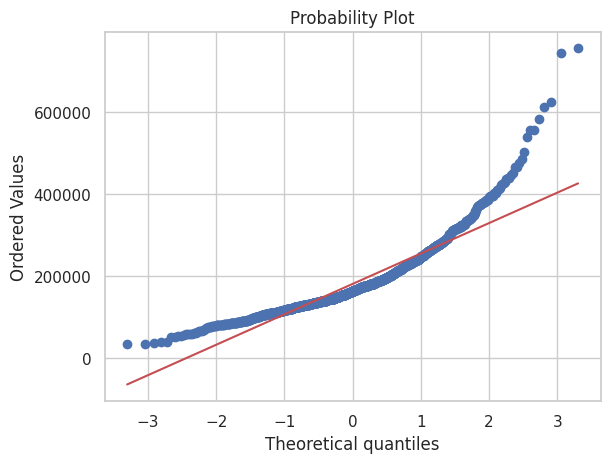

In [ ]:
# QQ Plot
fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(pd_train['SalePrice'], plot=plt)

2. **Dist plot**: A distribution plot (dist plot) is a graphical tool that shows the distribution of a sample of data. In this case, we used the dist plot to compare the distribution of sale prices to a normal distribution. The plot shows that the distribution of sale prices in the dataset is slightly skewed to the right, with a long tail of higher-priced houses. This is reflected in the curve of the normal distribution, which does not fit the data perfectly. However, the distribution is relatively close to normal, with most of the sale prices falling within two standard deviations of the mean. Overall, the dist plot suggests that the distribution of sale prices is not perfectly normal, but is approximately normal enough to allow us to use statistical methods that assume normality.



<ipython-input-89-27f3be249073>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd_train['SalePrice'] , fit=norm);


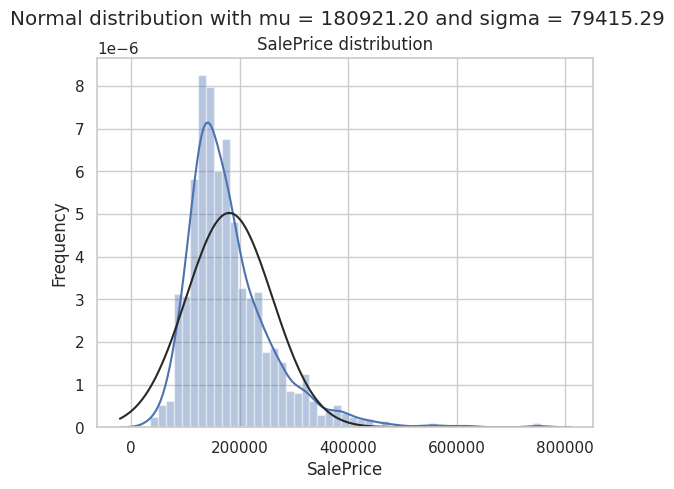

In [ ]:
# Dist Plot
sns.distplot(pd_train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(pd_train['SalePrice'])
plt.suptitle('Normal distribution with mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
plt.ylabel('Frequency')
plt.title('SalePrice distribution'); 

3. **Correlation**: We performed correlation among the features to examine how different features are related to the sale price of a house. The heatmap shows that some features are strongly correlated with the sale price of a house, while others are not. For example, the overall quality of the house (OverallQual) has a strong positive correlation with the sale price, while the age of the house (YearBuilt) has a weaker positive correlation. Other features, such as the presence of a fireplace (Fireplaces) or the size of the lot (LotArea), have a moderate positive correlation with the sale price.

> On the other hand, some features have negative correlations with the sale price, such as the distance from the house to a major road (MSSubClass), which has a weak negative correlation.

> Overall, examining correlation gave us insights into which features may be important predictors of the sale price of a house and which features have a negative impact on the price of the house.

In [ ]:
#Correlation
corr = pd_train.corr()
corr[['SalePrice']].sort_values(by='SalePrice',ascending=False).style.background_gradient(cmap='viridis', axis=None)

<ipython-input-90-0bcee2d8524c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = pd_train.corr()


,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


4. **Scatter plot and box plot between overall quality of a house and its sale price**: The scatter plot shows a clear positive relationship between the overall quality of a house and its sale price. As the overall quality increases, the sale price tends to increase as well. Additionally, there is some variability in the sale price at each level of overall quality, which may be due to other factors that influence the sale price, such as location or the size of the house. We can see that example, the median sale price for houses with an overall quality of 10 is over 400,000 USD, while the median sale price for houses with an overall quality of 1 is under $50,000.



> This plot suggests that the overall quality of a house is an important predictor of its sale price in the dataset. It also suggests that a linear regression model might be appropriate for modeling the relationship between the overall quality and sale price, as the relationship appears roughly linear. From this data analysis, we performed the Linear Regression model for prediction.

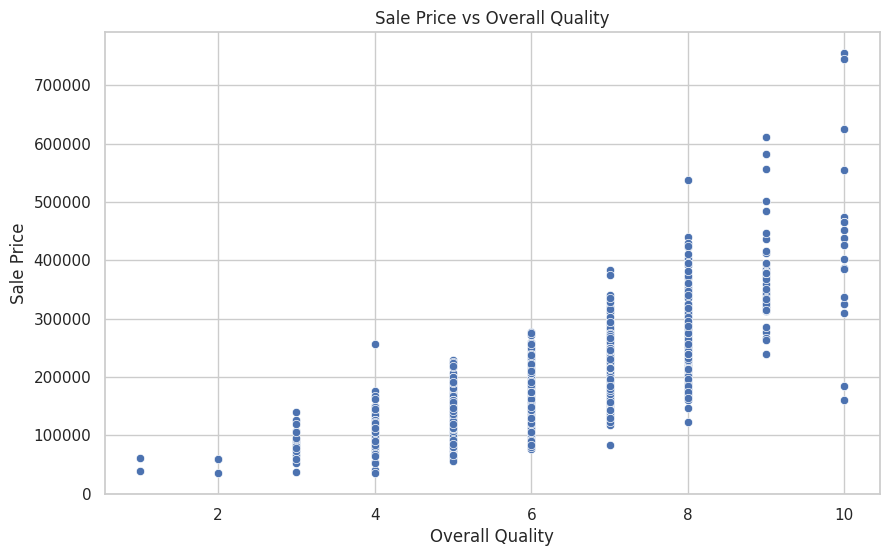

In [ ]:
#Overall quality of a house and its sale price:

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=pd_train)
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Overall Quality')
plt.show()

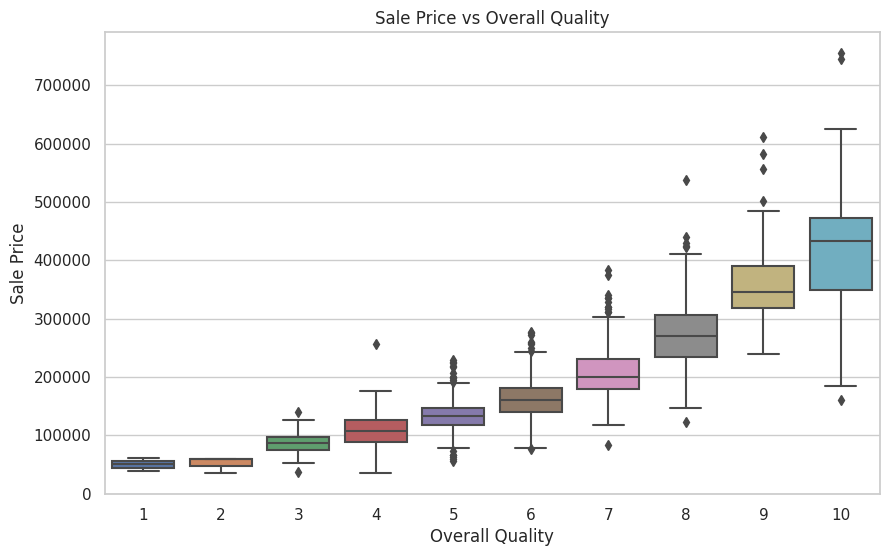

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=pd_train)
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Overall Quality')
plt.show()

5. **Bar plot between neighborhood and sale price**: We created a bar plot to show the average sale price for each neighborhood. Some neighborhoods in the dataset are associated with higher home prices than others, and this can be due to a variety of factors such as proximity to amenities, schools, or job opportunities. For example, houses located in the Northridge Heights or Stone Brook neighborhoods tend to have higher sale prices than those in other areas, likely due to their desirable location and amenities whereas houses in the Meadow Village have lower prices.

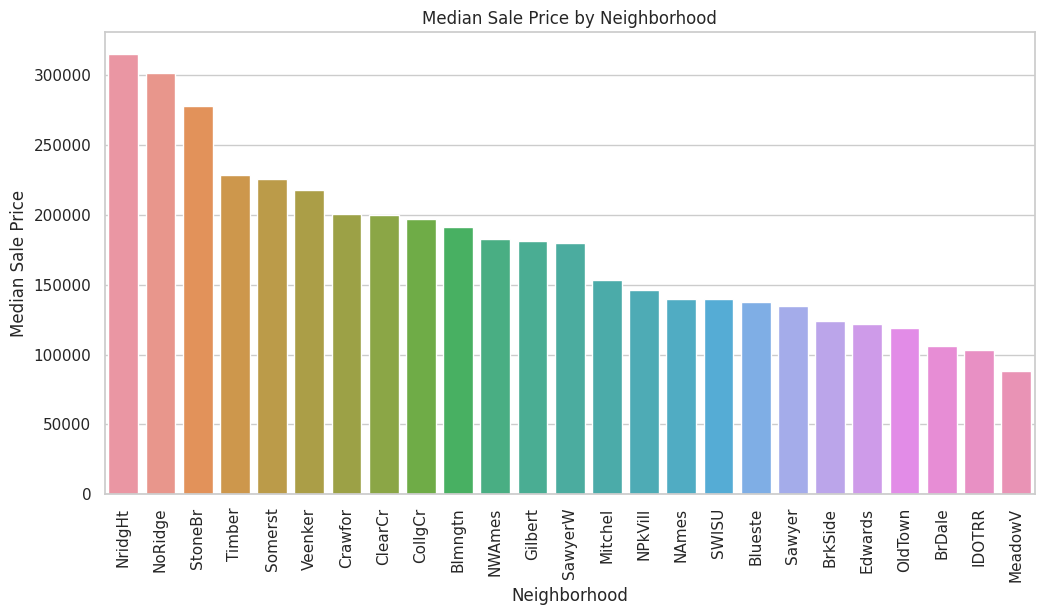

In [ ]:
neighborhood_prices = pd_train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False)
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(x=neighborhood_prices.index, y=neighborhood_prices.values)
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Median Sale Price')
plt.title('Median Sale Price by Neighborhood')
plt.show()


6. **Plot between Garage Area and Sale Price**: By grouping the data into categories based on garage area and then plotting the average sale price for each category, we can see how the sale price varies across different garage area ranges.

> In the bar plot, we can see that there is a general trend of increasing sale price as garage area increases, with the highest average sale price being associated with houses with a garage area of 800 square feet or more. However, there is also some variability within each category, indicating that there are other factors besides garage area that influence the sale price.

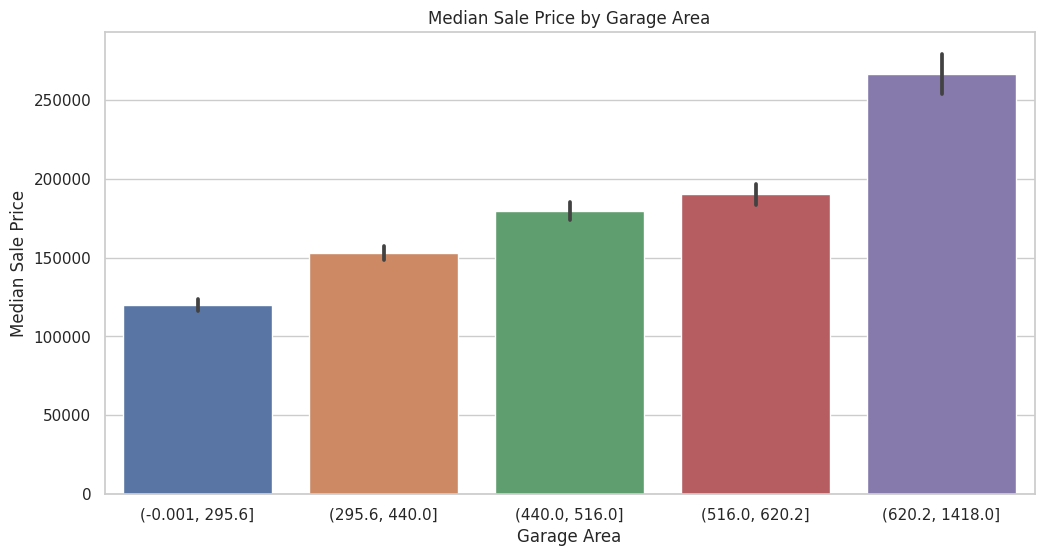

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(x=pd.qcut(pd_train['GarageArea'], 5), y=pd_train['SalePrice'])
plt.xlabel('Garage Area')
plt.ylabel('Median Sale Price')
plt.title('Median Sale Price by Garage Area')
plt.show()

7. **Total Basement Area and Sale Price**: We can see that there is a positive correlation between these two variables, indicating that larger basements are generally associated with higher sale prices. 

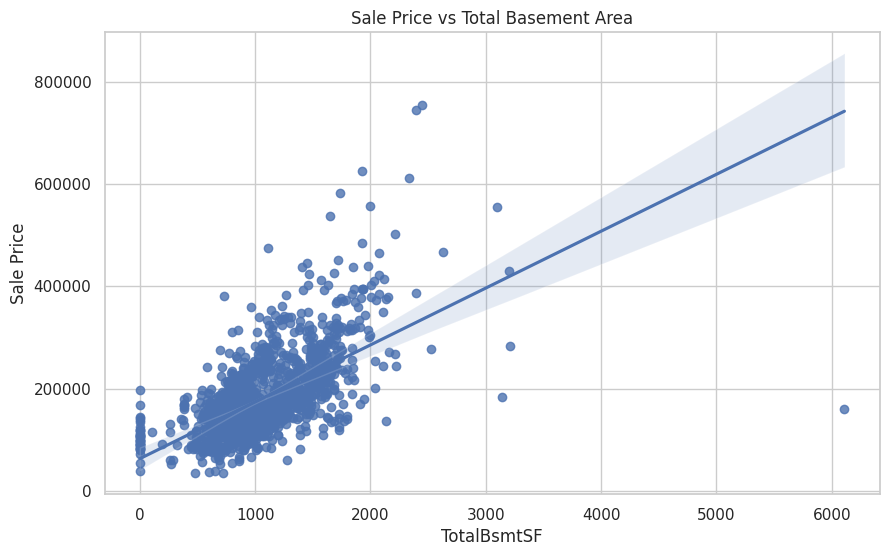

In [ ]:
#Total Basement Area and its sale price:

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=pd_train)
plt.xlabel('TotalBsmtSF')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Total Basement Area')
plt.show()

8. **Enclosed Porch and Sale Price**: We can see that there is a negative correlation between these two variables, indicating that larger enclosed porch areas are generally associated with lower sale prices. It is an interesting finding because having an enclosed porch is a luxury in most parts of the world.

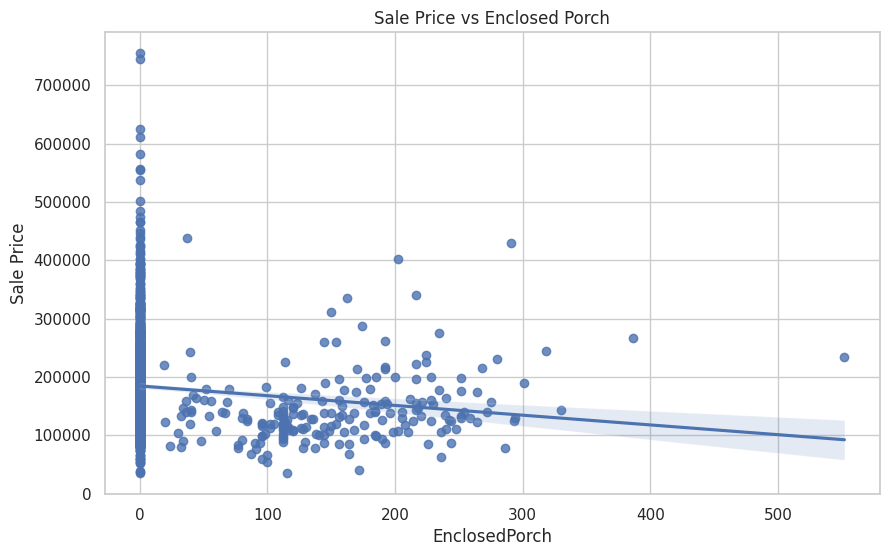

In [ ]:
#Enclosed Porch and its sale price:

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.regplot(x='EnclosedPorch', y='SalePrice', data=pd_train)
plt.xlabel('EnclosedPorch')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Enclosed Porch')
plt.show()

# **Methodology**

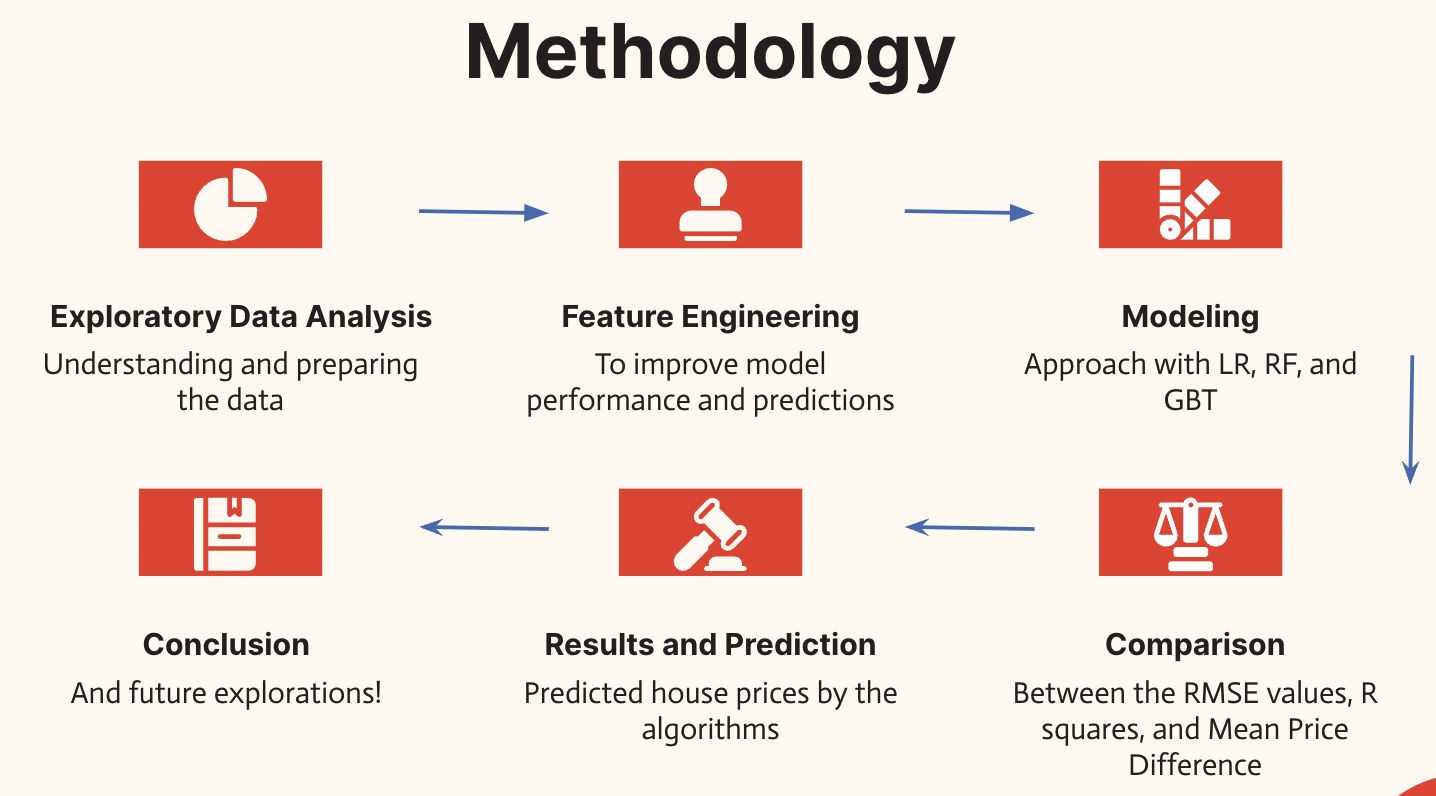


The methodology for this project is shown in the picture above. We have already discussed Exploratory Data Analysis.

In the next steps, we'll explain about.....

#####**Feature Engineering:**##### 
In this project We have encoured several issues including skewed data, outliers, and null values. To overcome those and make our model nearly perfect we have performed several steps of feature engineering.
#####**Modeling:**#####
We have prepared and deployed Linear Regression (With and without regularization), Gradiant Boosted Trees, and Random Forest.
#####**Comparison:**#####
According to the Kaggle competition, the model needs to be evaluated on the basis of RMSE (Root Mean Squared Error) value. Additionaly looking at RMSE and R squared value, we have also introduced a new measure which is Mean Price Difference (MPD) which is the average difference between the Predicted Price by the algorithm and Actual SalePrice.
#####**Results and Prediction:**#####
All the models have been evaluated on the basis of three above mentioned measures and their reliability. At the end, we also discussed about possibilities for future explorations. 



##**Feature Engineering**##

The feature engineering performed here are:

1. Null values and Outlier handling
2. Data transformation and creation
3. Regularization


###**1. Null values and Outlier handling**###

We have deleted colums that has missing values over 15%. The reason behind this are:

###**Enhanced Data Quality:**###

It may enhance the overall quality of dataset by deleting columns with more than 15% missing data. A significant portion of missing data might skew analysis' conclusions and impair its accuracy and dependability.

###**Reduced Dimensionality:**###

It is a good way to reduce the dimensionality of dataset by removing columns with a high percentage of missing data. This may facilitate data analysis and enhance the effectiveness of machine learning models that have been developed using the data.

###**Efficiency Gained:**###

Removing columns with a high percentage of missing data can help speed up data processing and analysis. A significant proportion of missing data can impede analysis and lengthen processing time when working with huge datasets.


On the basis of scatterplots and defined data range, we have dropped outliers that are most likely to be a data-entry error. We have dropped outliers from three features: Ground Living Area (GrLivArea), Sale Price (SalePrice) and Garage Area (GarageArea). We have deleted the outliers where Ground Living Area is more than 4500 sqft, Sale Price of the houses are less than $300000 and Garage Area of more than 1100 sq ft. 

In [ ]:
colors = ["#FF5F00", "#AD7BE9", "#03C988", "#0081B4", "#F48484",
          "#210062", "#CC3636", "#2DCDDF", "#FFB200", "#D5CEA3",
          "#54B435", "#EA047E", "#FFF80A", "#1D1CE5", "#FF0032"]

Text(0.5, 1.0, 'GarageArea vs SalePrice')

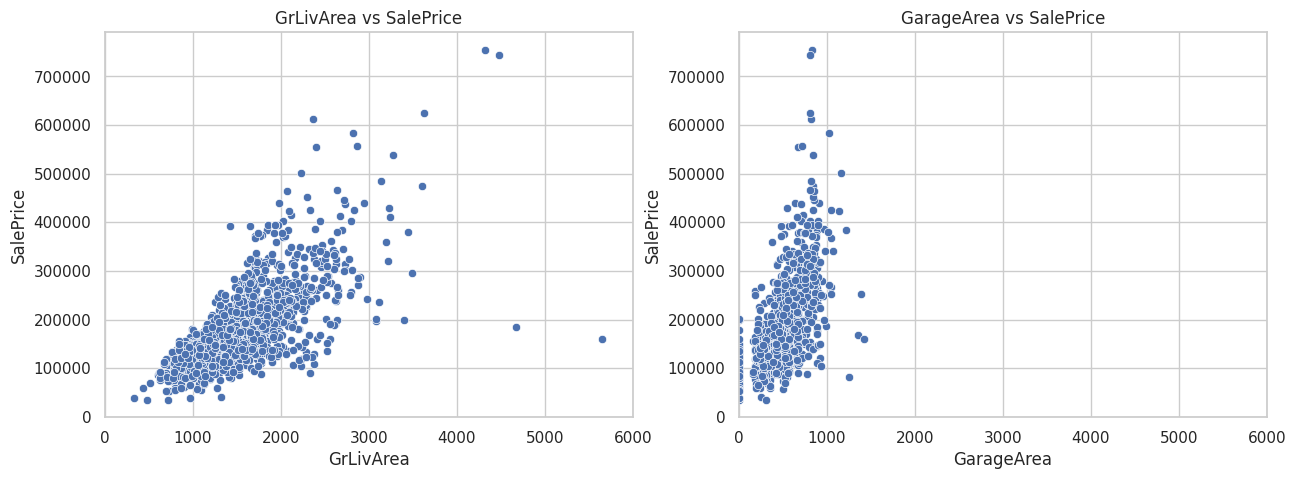

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')

Text(0.5, 1.0, '1stFlrSF vs SalePrice')

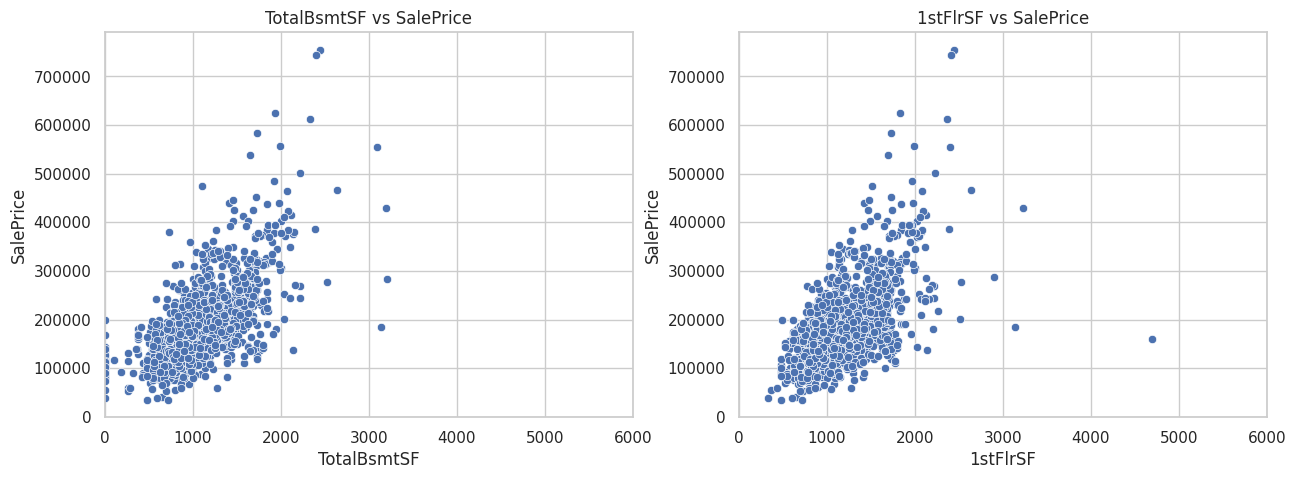

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='TotalBsmtSF', y='SalePrice')
axes[0].set_title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='1stFlrSF', y='SalePrice')
axes[1].set_title('1stFlrSF vs SalePrice')

In [ ]:
# We will remove features with missing proportion of more than 15% (thumb rule)
pd_train = pd_train.drop((missing[missing['Perc_missing'] >= 0.15]).index,1)
pd_train.head()

<ipython-input-100-1245fa3b517b>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pd_train = pd_train.drop((missing[missing['Perc_missing'] >= 0.15]).index,1)


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


###**Data transformation and creation**###

We have created a new feature by combining top three features strongly correlated with the target variable. A potent method for capturing non-linear correlations between variables is feature multiplication. In this instance, for instance, we have multiplied three features to represent the garage and the living area below, both of which are two dimensional. They may be multiplied to capture the object's area, which may be a more useful characteristic for some machine learning models. Along with this we have multiplied overall quality of the house which is considered an important factor and strongly correlated with target variable.


In [ ]:
pd_train['New'] = pd_train['OverallQual'] * pd_train['GarageArea'] * pd_train['GrLivArea']
pd_test['New'] = pd_test['OverallQual'] * pd_test['GarageArea'] * pd_test['GrLivArea']

In [ ]:
train_cols = list(pd_train.columns)
train_cols.remove('SalePrice')

In [ ]:
#Make test ds feature set same as in train ds
pd_test = pd_test[train_cols]

In [ ]:
pd_test.columns[pd_test.isna().any()].tolist()

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType',
 'New']

Understanding the context of the data and the cause of the missing values is crucial when dealing with missing values in a dataset. There may be characteristics in a collection of home information that correspond to the existence or lack of specific facilities, like a garage. It is possible that the appropriate properties connected to the garage (such as garage area, garage type, and condition) will have missing data if a given property does not have a garage.

It could be suitable to use a value, such as "None" or 0, to represent the lack of the amenity in place of the missing variables in this case. While not always the ideal option, this can be an acceptable course of action when missing data are anticipated to correlate to the absence of a certain functionality.



In [ ]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")
    
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    pd_train[col] = pd_train[col].fillna(0)
    pd_test[col] = pd_test[col].fillna(0)
    
pd_train['MasVnrType'] = pd_train['MasVnrType'].fillna("None")
pd_test['MasVnrType'] = pd_test['MasVnrType'].fillna("None")

pd_train['MasVnrArea'] = pd_train['MasVnrArea'].fillna(0)
pd_test['MasVnrArea'] = pd_test['MasVnrArea'].fillna(0)

pd_train['Electrical'] = pd_train['Electrical'].fillna(pd_train['Electrical'].mode()[0])
pd_test['Electrical'] = pd_test['Electrical'].fillna(pd_test['Electrical'].mode()[0])

print(pd_train.isnull().sum().max()) # check if any missing values are left
print(pd_test.isnull().sum().max())

0
4


In [ ]:
pd_test['BsmtFinSF1'] = pd_test['BsmtFinSF1'].fillna(pd_test['BsmtFinSF1'].mean())
pd_test['BsmtFinSF2'] = pd_test['BsmtFinSF2'].fillna(pd_test['BsmtFinSF2'].mean())
pd_test['BsmtUnfSF'] = pd_test['BsmtUnfSF'].fillna(pd_test['BsmtUnfSF'].mean())
pd_test['TotalBsmtSF'] = pd_test['TotalBsmtSF'].fillna(pd_test['TotalBsmtSF'].mean())
pd_test['BsmtFullBath'] = pd_test['BsmtFullBath'].fillna(pd_test['BsmtFullBath'].mean())
pd_test['BsmtHalfBath'] = pd_test['BsmtHalfBath'].fillna(pd_test['BsmtHalfBath'].mean())

In [ ]:
cat_columns = pd_train.select_dtypes(include=['object']).columns
pd_train[cat_columns] = pd_train[cat_columns].fillna('NoData')
pd_test[cat_columns] = pd_test[cat_columns].fillna('NoData')

In [ ]:
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>4500) 
                                & (pd_train['SalePrice']<300000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>5500) 
                                | (pd_train['SalePrice']>500000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[pd_train['GarageArea']>1100].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))

Dropping outliers resulted in 1460 instances in the new dataset
Dropping outliers resulted in 1458 instances in the new dataset
Dropping outliers resulted in 1449 instances in the new dataset
Dropping outliers resulted in 1444 instances in the new dataset


In [ ]:
train_df = spark_session.createDataFrame(pd_train)
test_df = spark_session.createDataFrame(pd_test)

In [ ]:
train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)

In [ ]:
from pyspark.sql.types import IntegerType

# As PySpark DFs can be finicky, sometimes your have to explicitly cast certain data types to columns

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

# train_df.printSchema()

In [ ]:
# Defining string columns to pass on to the String Indexer (= categorical feature encoding)

train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]


pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

In [ ]:
print(len(train_indexed.columns))

90


In [ ]:
# Create an empty list to hold the names of string columns in the test_df DataFrame
test_string_columns = []

# Iterate over each column and data type in the test_df DataFrame using the dtypes attribute
for col, dtype in test_df.dtypes:
    # Check if the data type of the column is a string
    if dtype == 'string':
        # If the data type is a string, append the name of the column to the test_string_columns list
        test_string_columns.append(col)


In [ ]:
# Create a list of StringIndexer objects, one for each string column in the test_df DataFrame
indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(test_df) for column in test_string_columns]

# Create a Pipeline object to apply the StringIndexer transformations to the test_df DataFrame
pipeline2 = Pipeline(stages=indexers2)

# Apply the Pipeline object to the test_df DataFrame to create a new DataFrame with the string columns encoded as categorical features
test_indexed = pipeline2.fit(test_df).transform(test_df)


In [ ]:
print(len(test_indexed.columns))

89


In [ ]:
def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))
        
num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed,col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

In [ ]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))

63
62


###**Regularization**###

* L1 and L2 regularization techniques can be used in the Ames Housing Dataset to improve the performance and generalizability of the linear regression model.

* L1 regularization (also known as Lasso regularization) works by adding a penalty term to the linear regression objective function, which encourages the coefficients of less important features to be set to zero. This can help with feature selection and reduce overfitting in models with many variables.

* L2 regularization (also known as Ridge regularization) adds a penalty term to the objective function that discourages the model from using large coefficients for any of the features. This can also help with feature selection and reduce overfitting.

* Both L1 and L2 regularization can help improve the performance of the linear regression model by reducing the impact of noisy or irrelevant features, and by increasing the model's ability to generalize to new data. Additionally, these techniques can help with interpretability by identifying the most important features in the model.



#Model Prediction

We have predicted the sale price of the houses using three machine learning algorithms:
1. Linear Regression
2. Random Forest
3. Gradient Boosted Trees

**Modeling Approach**

| Model | Split | Parameters 
|------|-------------|------|
| Linear Regression | 70:30 | Max. Iteration - 10
|  |  | 		                  RegParam - 0.8
|  |  | 		                  ElasticNetParam - 0.1 | 26245.72 |
| Random Forest | 70:30 | Max. Depth - 20
|  |  | 		              Min. instances per node- 2
|  |  | 		              Bootstrap - True |
| Gradient Boosted Trees | 70:30 | Max. Depth - 5
|  |  | 		                       Min. Iteration- 50 | 



In [ ]:
# Importing the VectorAssembler from PySpark's ML library
from pyspark.ml.feature import VectorAssembler

# Creating a VectorAssembler to combine all input columns (except SalePrice) into a single features column
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("SalePrice").columns, outputCol = 'features').setHandleInvalid("keep")

# Transforming the train DataFrame to include the new features column
train_vector = vectorAssembler.transform(train_indexed)


In [ ]:
# Create a VectorAssembler to convert test dataframe to vector representation
vectorAssembler2 = VectorAssembler(inputCols = test_indexed.columns, outputCol = 'features').setHandleInvalid("keep")

# Apply the VectorAssembler on test dataframe to get features column
test_vector = vectorAssembler2.transform(test_indexed)


In [ ]:
from pyspark.sql.functions import lit

test_vector = test_vector.withColumn("SalePrice", lit(0))

In [ ]:
#You can use this to scale all instances, however, as I checked, this did not improve the performance

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train_vector)
scaled_train = scalerModel.transform(train_vector)

scalerModel2 = scaler.fit(test_vector)
scaled_test = scalerModel2.transform(test_vector)

In [ ]:
# Train-test split

splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

#1. Linear Regression 

Reasons behind opting for Linear Regression algorithm are:

###**Handling Data**###

The dataset contains numerous continuous and categorical variables, and linear regression can handle both types of data. This allows us to explore the relationships between different variables and their impact on the sale price of a house.

###**Simple and interpretable**###

Linear regression is a relatively simple and interpretable model, which can help us understand the underlying trends and patterns in the data. It can also help us identify important features that contribute significantly to the variation in sale price, which can be useful in making predictions and identifying potential areas for improvement.

###**Regularization and overfitting**###

Finally, linear regression can be used with regularization techniques such as L1 and L2 regularization, which can help prevent overfitting and improve the generalizability of the model. This can be particularly important in the Ames Housing Dataset, which contains a relatively small number of observations and a large number of variables. Overall, linear regression is a powerful and flexible tool for analyzing the Ames Housing Dataset and can provide valuable insights into the factors that influence the sale price of a house.



**Summary Table:**



| Value predicted | Model Type | Scoring Metric | Model Score |
|------|-------------|------|---------|
| Sale Price | Linear Regression | RMSE | 21888.44 |
| Sale Price | Linear Regression | R square | 0.91 |
| Sale Price | Linear Regression | Mean Percentage Difference | 10.63 % |
| Sale Price | Linear Regression with L1 regularization | RMSE | 21888.42 |
| Sale Price | Linear Regression with L1 regularization | R square | 0.91 |
| Sale Price | Linear Regression with L1 regularization | Mean Percentage Difference | 10.63% |
| Sale Price | Linear Regression with L2 regularization | RMSE | 21163.06 |
| Sale Price | Linear Regression with L2 regularization | R square | 0.91 |
| Sale Price | Linear Regression with L2 regularization | Mean Percentage Difference | **9.95%** |



Apart from using Linear Regression, we also performed L1 and L2 regularization techniques to improve the performance and generalizability of the linear regression model. But we saw that for L1 regularization, there was no effect on the RMSE, R square and mean percentage difference values. L2 regularization helped to reduce the RMSE value and produced the best R-square value. It also reduced the mean percentage difference to 9.95%. So, Ridge regularization (L2) definitely perfomed better than L1 and Linear Regression without regularization models. 

In [ ]:
# Import LinearRegression from pyspark.ml.regression
from pyspark.ml.regression import LinearRegression

# Instantiate a LinearRegression object with the input and output columns, along with optional hyperparameters.
lr = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=10, regParam=0.8, elasticNetParam=0.1)

# Fit the LinearRegression model on the training data
lr_model = lr.fit(train)

# Get summary statistics of the trained model, including rootMeanSquaredError and r2
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

# Use the trained model to predict SalePrice on validation data, and display the first 5 rows of the predictions along with the SalePrice and features columns
lr_predictions = lr_model.transform(val)
lr_predictions = lr_predictions.withColumn("Difference", lr_predictions["prediction"] - lr_predictions["SalePrice"])
lr_predictions = lr_predictions.withColumn("Percentage Difference", lr_predictions["Difference"] / lr_predictions["SalePrice"] * 100)
lr_predictions.select("Prediction","SalePrice","Difference", "Percentage Difference", "features").show(5)

# Instantiate a RegressionEvaluator to evaluate the predictions of the trained model on validation data
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="r2")

from pyspark.sql.functions import abs, col, expr

lr_predictions = lr_predictions.withColumn("Difference", abs(lr_predictions["SalePrice"] - lr_predictions["prediction"]))

# Calculate the percentage difference between predicted and actual SalePrice, and add it to the dataframe
lr_predictions = lr_predictions.withColumn("Percent Diff", expr("100 * abs(SalePrice - prediction) / SalePrice"))

# Calculate the mean difference and mean percentage difference between predicted and actual SalePrice
mean_diff = lr_predictions.selectExpr("mean(Difference)").collect()[0][0]
mean_percent_diff =lr_predictions.selectExpr("mean(`Percent Diff`)").collect()[0][0]

# Print the mean difference and mean percentage difference
print("Mean Difference: %f" % mean_diff)
print("Mean Percent Difference: %f%%" % mean_percent_diff)

# Evaluate the model's R-squared (R2) value on the validation data
print("R Squared (r2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

# Set variables for R2 and RMSE scores
lr_r2 = trainingSummary.r2 
lr_rmse = trainingSummary.rootMeanSquaredError


RMSE: 21888.444229
r2: 0.910130
+------------------+---------+-------------------+---------------------+--------------------+
|        Prediction|SalePrice|         Difference|Percentage Difference|            features|
+------------------+---------+-------------------+---------------------+--------------------+
| 275668.8214082909|   307000| -31331.17859170912|   -10.20559563247854|(62,[0,1,2,3,4,5,...|
|  349950.222014145|   345000|  4950.222014144994|   1.4348469606217373|(62,[0,1,2,3,4,5,...|
|229324.37335827062|   279500| -50175.62664172938|   -17.95192366430389|(62,[0,1,2,3,4,5,...|
|140868.90397053957|   132000|   8868.90397053957|    6.718866644348159|(62,[0,1,2,3,4,5,...|
|127522.99095278606|   139000|-11477.009047213942|   -8.256841041161108|(62,[0,1,2,3,4,5,...|
+------------------+---------+-------------------+---------------------+--------------------+
only showing top 5 rows

Mean Difference: 16837.979432
Mean Percent Difference: 10.630443%
R Squared (r2) on val data = 0.

##Linear Regression with L1 regularization

In [ ]:
# Import LinearRegression from pyspark.ml.regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import abs, expr, col

# Instantiate a LinearRegression object with L1 regularization, along with input/output columns and optional hyperparameters.
lr_l1 = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=10, regParam=0.1, elasticNetParam=1.0)

# Fit the LinearRegression model on the training data
lr_model_l1 = lr_l1.fit(train)

# Get summary statistics of the trained model, including rootMeanSquaredError and r2
trainingSummary_l1 = lr_model_l1.summary
print("RMSE: %f" % trainingSummary_l1.rootMeanSquaredError)
print("r2: %f" % trainingSummary_l1.r2)

# Use the trained model to predict SalePrice on validation data, and display the first 5 rows of the predictions along with the SalePrice and features columns
lr_predictions_l1 = lr_model_l1.transform(val)

# Instantiate a RegressionEvaluator to evaluate the predictions of the trained model on validation data
lr_evaluator_l1 = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="r2")

# Evaluate the model's R-squared (R2) value on the validation data
print("R Squared (r2) on val data = %g" % lr_evaluator_l1.evaluate(lr_predictions_l1))

# Compute the difference between predicted price and sales price for the L1 regularized model
lr_diff_l1 = lr_predictions_l1.withColumn('Difference', abs(col('SalePrice')-col('prediction')))

# Compute the percentage difference between the predicted price and actual price for the L1 regularized model
lr_diff_l1 = lr_diff_l1.withColumn('Percentage Difference', (col('Difference')/col('SalePrice'))*100)

# Show the difference and percentage difference between predicted price and actual price for the L1 regularized model
lr_diff_l1.select('SalePrice', 'prediction', 'Difference', 'Percentage Difference').show(5)

# Calculate the difference between predicted and actual SalePrice, and add it to the dataframe
lr_predictions_l1 = lr_predictions_l1.withColumn("Diff", abs(col("SalePrice") - col("prediction")))

# Calculate the percentage difference between predicted and actual SalePrice, and add it to the dataframe
lr_predictions_l1 = lr_predictions_l1.withColumn("Percent Diff", expr("100 * abs(SalePrice - prediction) / SalePrice"))
# Calculate the mean difference and mean percentage difference between predicted and actual SalePrice
mean_diff = lr_predictions_l1.selectExpr("mean(Diff)").collect()[0][0]
mean_percent_diff =lr_predictions_l1.selectExpr("mean(`Percent Diff`)").collect()[0][0]

# Print the mean difference and mean percentage difference
print("Mean Difference: %f" % mean_diff)
print("Mean Percent Difference: %f%%" % mean_percent_diff)
lr_l1_r2=trainingSummary_l1.r2
lr_l1_rmse = trainingSummary_l1.rootMeanSquaredError

RMSE: 21888.425673
r2: 0.910130
R Squared (r2) on val data = 0.883909
+---------+------------------+------------------+---------------------+
|SalePrice|        prediction|        Difference|Percentage Difference|
+---------+------------------+------------------+---------------------+
|   307000| 275668.9904276058|31331.009572394192|   10.205540577327099|
|   345000|  349950.345762215| 4950.345762214973|   1.4348828296275282|
|   279500|229324.16545988666| 50175.83454011334|   17.951998046552177|
|   132000|140868.95277723856| 8868.952777238563|    6.718903619120123|
|   139000|127523.10430881567|11476.895691184327|    8.256759490060666|
+---------+------------------+------------------+---------------------+
only showing top 5 rows

Mean Difference: 16837.994762
Mean Percent Difference: 10.630459%


## Linear Regression with L2 regularisation

In [ ]:
from pyspark.ml.regression import LinearRegression

# Instantiate a LinearRegression object with the input and output columns, along with L2 regularization parameter
lr_l2 = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=10, regParam=0.1, elasticNetParam=0.0)

# Fit the LinearRegression model on the training data
lr_l2_model = lr_l2.fit(train)

# Get summary statistics of the trained model, including rootMeanSquaredError and r2
trainingSummary_l2 = lr_l2_model.summary
print("RMSE: %f" % trainingSummary_l2.rootMeanSquaredError)
print("r2: %f" % trainingSummary_l2.r2)


RMSE: 21163.063121
r2: 0.915988


In [ ]:
from pyspark.sql.functions import col, abs, expr, when

# Use the trained model to make predictions on validation data
lr_l2_predictions = lr_l2_model.transform(val)

# Calculate the difference between predicted and actual SalePrice, and add it to the dataframe
lr_l2_predictions = lr_l2_predictions.withColumn("Diff", abs(col("SalePrice") - col("prediction")))

# Calculate the percentage difference between predicted and actual SalePrice, and add it to the dataframe
lr_l2_predictions = lr_l2_predictions.withColumn("Percent Diff", expr("100 * abs(SalePrice - prediction) / SalePrice"))

# Show the first 5 rows of the dataframe with the added columns
lr_l2_predictions.select("prediction", "SalePrice", "Diff", "Percent Diff").show(5)

# Instantiate a RegressionEvaluator to evaluate the predictions of the trained model on validation data
lr_l2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="r2")

# Evaluate the model's R-squared (R2) value on the validation data
print("R Squared (r2) on val data = %g" % lr_l2_evaluator.evaluate(lr_l2_predictions))

# Store the RMSE and R2 values of the model
lr_l2_rmse = trainingSummary_l2.rootMeanSquaredError
lr_l2_r2 = trainingSummary_l2.r2

# Print the RMSE and R2 values of the model
print("RMSE: %f" % lr_l2_rmse)
print("R2 Score: %f" % lr_l2_r2)

# Calculate the mean difference and mean percentage difference between predicted and actual SalePrice
mean_diff = lr_l2_predictions.selectExpr("mean(Diff)").collect()[0][0]
mean_percent_diff = lr_l2_predictions.selectExpr("mean(`Percent Diff`)").collect()[0][0]

# Print the mean difference and mean percentage difference
print("Mean Difference: %f" % mean_diff)
print("Mean Percent Difference: %f%%" % mean_percent_diff)


+------------------+---------+------------------+------------------+
|        prediction|SalePrice|              Diff|      Percent Diff|
+------------------+---------+------------------+------------------+
|273795.01099231734|   307000|33204.989007682656|10.815957331492722|
| 358553.0944703912|   345000|13553.094470391225|3.9284331798235432|
|225470.46648318938|   279500|54029.533516810625|19.330781222472496|
|129856.43712998775|   132000| 2143.562870012247|1.6239112651607932|
| 132349.3867519732|   139000| 6650.613248026813| 4.784613847501305|
+------------------+---------+------------------+------------------+
only showing top 5 rows

R Squared (r2) on val data = 0.892213
RMSE: 21163.063121
R2 Score: 0.915988
Mean Difference: 15944.393499
Mean Percent Difference: 9.950216%


### Comparing the linear regression models

In [ ]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, lit

# Create a Spark session
spark = SparkSession.builder.appName('Model Comparison').getOrCreate()

# Create a dataframe with the model names and their respective R2 and RMSE scores
model_names = ['Linear Regression', 'L1 Regularization', 'L2 Regularization']
r2_scores = [lr_r2, lr_l1_r2, lr_l2_r2]
rmse_scores = [lr_rmse, lr_l1_rmse, lr_l2_rmse]
model_df = spark.createDataFrame([(model_names[i], r2_scores[i], rmse_scores[i]) for i in range(len(model_names))], ['Model', 'R2 Score', 'RMSE'])

# Add a column to identify the best performing model
best_r2 = max(r2_scores)
best_rmse = min(rmse_scores)
model_df = model_df.withColumn('Best Model', 
                               when(col('R2 Score') == best_r2, lit('R2')).otherwise(
                               when(col('RMSE') == best_rmse, lit('RMSE')).otherwise(lit('None'))))

# Show the dataframe
model_df.show()


+-----------------+------------------+------------------+----------+
|            Model|          R2 Score|              RMSE|Best Model|
+-----------------+------------------+------------------+----------+
|Linear Regression|0.9101298402297789|21888.444228586624|      None|
|L1 Regularization|0.9101299926057547| 21888.42567251379|      None|
|L2 Regularization|0.9159877183006199| 21163.06312059647|        R2|
+-----------------+------------------+------------------+----------+



#2. Random Forest

Reasons behind opting for Random Forest algorithm are:

####**High Accuracy:**#### 
Because Random Forest models employ several decision trees and combine the outcomes to produce predictions, they are renowned for their high accuracy. As overfitting is typical with single decision tree models, this lowers the probability of it happening.
####**Robustness:**#### 
Because individual data points have no impact on Random Forest models, they are resistant to noisy data and outliers. As out data is outlier heavy, it's possible 
####**Feature Importance:**####
The relevance of various features in the dataset may also be determined using Random Forest models, which is helpful for feature selection and interpretation.
####**Speed:**#### 
When compared to more sophisticated machine learning techniques like neural networks, training a Random Forest model is rather quick.

**Summary Table:**



| Value predicted | Model Type | Scoring Metric | Model Score |
|------|-------------|------|---------|
| Sale Price | Random Forest | RMSE | 23634 |
| Sale Price | Random Forest | R square | 0.87 |
| Sale Price | Random Forest | Mean Percentage Difference | 10.50 % |

The Random Forest Model did not perform to our expectations. It produced a low R-square value of 0.87 and a large RMSE value. It may be due to the fact that the dataset has a relatively small number of observations and a large number of variables. Random Forest tends to perform better when there are a large number of observations and a smaller number of variables. Also as the dataset had a lot of missing data, Random Forest was not as effective at handling missing or categorical data as other algorithms such as linear regression. 

In [ ]:
# A more complex model with RF
from pyspark.ml.regression import RandomForestRegressor

# Initialize the RandomForestRegressor model with the desired hyperparameters
rf = RandomForestRegressor(featuresCol='features', labelCol='SalePrice', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                           bootstrap=True)

# Fit the model to the training data
rf_model = rf.fit(train)

# Make predictions on the validation data using the trained model
rf_predictions = rf_model.transform(val)



In [ ]:
from pyspark.sql.functions import abs, col, expr

# Make predictions on the validation data using the trained model
rf_predictions = rf_model.transform(val)

# Add columns for the difference and percentage difference between the predicted and actual SalePrice
rf_predictions = rf_predictions.withColumn('Diff', abs(col('prediction') - col('SalePrice'))) \
                                 .withColumn('Perc Diff', expr('100 * abs(prediction - SalePrice) / SalePrice'))

# Calculate the mean difference and mean percentage difference between predicted and actual SalePrice
mean_diff = rf_predictions.agg({'Diff': 'mean'}).collect()[0][0]
mean_perc_diff = rf_predictions.agg({'Perc Diff': 'mean'}).collect()[0][0]

# Print the mean difference and mean percentage difference
print('Mean Difference: ', mean_diff)
print('Mean Percentage Difference: ', mean_perc_diff)

# Show the first 5 rows of the predictions with the difference and percentage difference columns
rf_predictions.select("prediction","SalePrice", "Diff", "Perc Diff").show(5)

# Evaluate the model on the validation data using the R^2 metric
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice", metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

rf_r2 = rf_evaluator.evaluate(rf_predictions)


Mean Difference:  16715.549132087424
Mean Percentage Difference:  10.505975717865619
+------------------+---------+------------------+-----------------+
|        prediction|SalePrice|              Diff|        Perc Diff|
+------------------+---------+------------------+-----------------+
|278353.22500000003|   307000|28646.774999999965|9.331197068403897|
|353926.61666666664|   345000|  8926.61666666664|2.587425120772939|
|222153.75499999998|   279500|57346.245000000024|20.51744007155636|
|143808.91666666666|   132000|11808.916666666657|8.946148989898981|
|141825.41666666666|   139000| 2825.416666666657|2.032673860911264|
+------------------+---------+------------------+-----------------+
only showing top 5 rows

R Squared (R2) on val data = 0.878359


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % rf_rmse)

Root Mean Squared Error (RMSE) on val data = 23634


#3. Gradient Boosted Trees



GBT is very similar algorithm as random Forest. instead of having many similar benefits, there are certain differences.

* Random Forest reduces the variance of the model by building multiple independent decision trees, while GBT Regressor reduces the bias of the model by sequentially adding new trees that correct the errors of the previous trees. As our data is not normally distributed, this may be helpful for betterment of some of the defined metrics.

* Also the fact that, GBT Regressor  it can adjust the weights of the data points based on their importance, it may be more beneficial while handling outliers.

Reasons behind opting for Gradient Boosted Tress algorithm are:

###**Non-linear relationships**###

The dataset contains several variables that have non-linear relationships with the target variable, SalePrice. GBT is capable of capturing non-linear relationships, making it a suitable algorithm for this dataset.

###**Feature importance**###

GBT can provide insight into the importance of different features in predicting the target variable. This is particularly useful in the context of the dataset, which contains many features that may or may not be important in predicting SalePrice.

###**Robustness to outliers**###

GBT is generally more robust to outliers than other algorithms like linear regression. This is important in the context of the dataset, which contains some outliers that may negatively impact model performance.


**Summary Table:**



| Value predicted | Model Type | Scoring Metric | Model Score |
|------|-------------|------|---------|
| Sale Price | Gradient Boosted Trees | RMSE | 29218.4 |
| Sale Price | Gradient Boosted Trees | R square | 0.81 |
| Sale Price | Gradient Boosted Trees | Mean Percentage Difference | 12.04 % |

GBT performed poorly well in terms of the mean percentage difference measure. It showed a difference of 12.04% which is the highest among the other two algorithms performed. 

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a GBTRegressor object
gbt = GBTRegressor(featuresCol='features', labelCol='SalePrice', maxDepth=5, maxIter=50)

# Train the model on the training set
gbt_model = gbt.fit(train)

# Make predictions on the validation set
gbt_predictions = gbt_model.transform(val)

# Evaluate the model's performance using R squared metric
gbt_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice', metricName='r2')
r2 = gbt_evaluator.evaluate(gbt_predictions)

print("R Squared (R2) on val data = %g" % r2)
gbt_r2=r2


R Squared (R2) on val data = 0.814083


In [ ]:
from pyspark.sql.functions import abs, col, expr

# Make predictions on the validation set using the trained model
gbt_predictions = gbt_model.transform(val)

# Add columns for the difference and percentage difference between the predicted and actual SalePrice
gbt_predictions = gbt_predictions.withColumn('Diff', abs(col('prediction') - col('SalePrice'))) \
                                 .withColumn('Perc Diff', expr('100 * abs(prediction - SalePrice) / SalePrice'))

# Calculate the mean difference and mean percentage difference between predicted and actual SalePrice
mean_diff = gbt_predictions.agg({'Diff': 'mean'}).collect()[0][0]
mean_perc_diff = gbt_predictions.agg({'Perc Diff': 'mean'}).collect()[0][0]

# Print the mean difference and mean percentage difference
print('Mean Difference: ', mean_diff)
print('Mean Percentage Difference: ', mean_perc_diff)

# Show the first 5 rows of the predictions with the difference and percentage difference columns
gbt_predictions.select('prediction', 'SalePrice', 'Diff', 'Perc Diff').show(5)

# Evaluate the model's performance using R squared metric
gbt_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice', metricName='r2')
r2 = gbt_evaluator.evaluate(gbt_predictions)

print("R Squared (R2) on val data = %g" % r2)
gbt_r2 = r2


Mean Difference:  20103.212687350653
Mean Percentage Difference:  12.04489666646437
+------------------+---------+------------------+------------------+
|        prediction|SalePrice|              Diff|         Perc Diff|
+------------------+---------+------------------+------------------+
| 276530.1516001714|   307000|30469.848399828596| 9.925032052061432|
| 371818.8195948826|   345000|26818.819594882603|7.7735708970674215|
| 210385.8055539831|   279500| 69114.19444601689|24.727797655104432|
|123728.14841881528|   132000| 8271.851581184717|  6.26655422817024|
|  111300.555313628|   139000|27699.444686371993|19.927658047749635|
+------------------+---------+------------------+------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.814083


In [ ]:
# Evaluate the model's performance using RMSE metric
gbt_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice', metricName='rmse')
rmse = gbt_evaluator.evaluate(gbt_predictions)

print("Root Mean Square Error (RMSE) on val data = %g" % rmse)
gbt_rmse = rmse


Root Mean Square Error (RMSE) on val data = 29218.4


#Model Inference

##**1. Linear Regression Inference of Sale Price Prediction**##


| Feature predicted | Model Type | Scoring Metric | Model Score |
|------|-------------|------|---------|
| Sale Price | Linear Regression | RMSE | 21888.44 |
| Sale Price | Linear Regression | R square | 0.91 |
| Sale Price | Linear Regression | Mean Percentage Difference | 10.63 % |
| Sale Price | Linear Regression with L1 regularization | RMSE | 21888.42 |
| Sale Price | Linear Regression with L1 regularization | R square | 0.91 |
| Sale Price | Linear Regression with L1 regularization | Mean Percentage Difference | 10.63% |
| Sale Price | Linear Regression with L2 regularization | RMSE | 21163.06 |
| Sale Price | Linear Regression with L2 regularization | R square | 0.91 |
| Sale Price | Linear Regression with L2 regularization | Mean Percentage Difference | **9.95%** |

1. **Inference Goal**: 

* The goal is to predict the sale price of a house based on the given features in the dataset using linear regression.

* Identify the important features affecting the sale price of the house.

2. **Insights from Analysis**:

* Linear Regression outperformed GBT and Random Forest models in terms of RMSE, R-square values, and mean percentage difference. It produced an RMSE score of 21888.44 and a R-square of 0.91. It also had the lowest mean percentage difference of 9.95%.


* The most important features affecting the sale price of the house were found to be the exterior quality of the house, ground living area, full bath and lot area of the house.

3. **Special Transformations**:

* L1 and L2 regularization techniques were applied to prevent overfitting and improve the model's generalization performance.

##**2. Random Forest Inference of Sale Price Prediction**##


| Value predicted | Model Type | Scoring Metric | Model Score |
|------|-------------|------|---------|
| Sale Price | Random Forest | RMSE | 23634 |
| Sale Price | Random Forest | R square | 0.87 |
| Sale Price | Random Forest | Mean Percentage Difference | 10.50 % |

1. **Inference Goal**:

* The inference goal of using the Random Forest model in the Ames Housing Dataset is to predict the sale price of a house based on its features.


2. **Insights from analysis**: 

* The model achieved a low R-square value of around 0.87 and also a high mean percentage difference of 10.50%.

* The important features for the model were found to be the quality of the house, the second floor area of the house, the lot area, and the exterior quality of the house.


3. **Special Transformations**:

* No feature scaling or regularization techniques were used in this model.

##**3. Gradient Boosted Trees Inference of Sale Price Prediction**##


| Value predicted | Model Type | Scoring Metric | Model Score |
|------|-------------|------|---------|
| Sale Price | Gradient Boosted Trees | RMSE | 29218.4 |
| Sale Price | Gradient Boosted Trees | R square | 0.81 |
| Sale Price | Gradient Boosted Trees | Mean Percentage Difference | 12.04 % |



1. **Inference Goal**:

* The inference goal of using the Gradient Boosted Trees model in the Ames Housing Dataset is to predict the sale price of houses.


2. **Insights from analysis**: 

* Gradient Boosted Trees performed poorly than Linear Regression and Random Forest models. 

* The important features for the model were found to be the quality of the house, the second floor area of the house, the lot area, and the exterior quality of the house.

* The feature importance showed that the importance features were the same as Random Forest Model.


3. **Special Transformations**:

* No feature scaling or regularization techniques were used in this model.

##R-square values comparison

| Model | R-squared values |
|------||
| Linear Regression | 0.91 |
| Random Forest | 0.87 |
| Gradient Boosted Trees | 0.81 |

Linear Regression showed the highest R-squared values of 0.91 whereas GBT showed the lowest R-squared value of 0.81.

                         Model Name  R Squared
0                 Linear Regression   0.910130
1          Random Forest Regression   0.878359
2  Gradient Boosted Tree Regression   0.814083


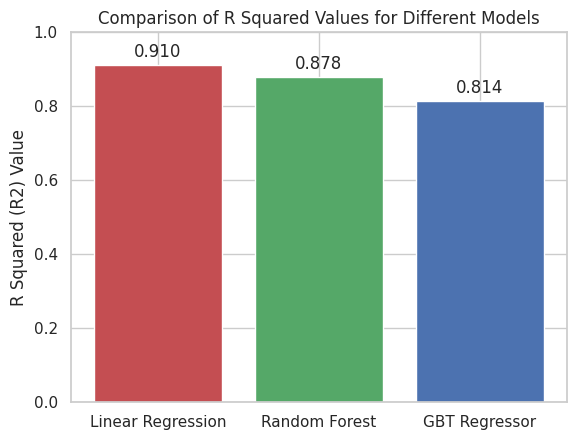

In [ ]:
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Pandas DataFrame to hold the results
data = {"Model Name": ["Linear Regression", "Random Forest Regression", "Gradient Boosted Tree Regression"],
        "R Squared": [lr_r2, rf_r2, gbt_r2]}
results_df = pd.DataFrame(data=data)

# Print the results DataFrame
print(results_df)

import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'Random Forest', 'GBT Regressor']
r2_values = [lr_r2, rf_r2, gbt_r2]

fig, ax = plt.subplots()
rects = ax.bar(models, r2_values, color=['r', 'g', 'b'])
ax.set_ylim([0, 1])
ax.set_ylabel('R Squared (R2) Value')
ax.set_title('Comparison of R Squared Values for Different Models')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()

###RMSE values comparison

| Model | RMSE values |
|------||
| Linear Regression | 21888.44 |
| Random Forest | 23634.01 |
| Gradient Boosted Trees | 29218.42 |

Linear Regression showed the lowest RMSE values of 21888.44

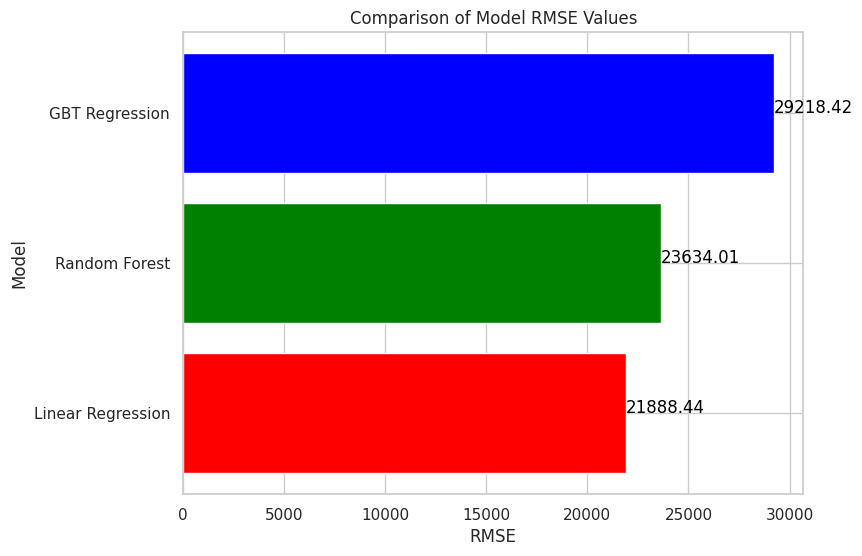

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the RMSE values for each model
rmse_values = [lr_rmse, rf_rmse, gbt_rmse]

# Define the model names
model_names = ['Linear Regression', 'Random Forest', 'GBT Regression']

# Create a DataFrame with the RMSE values and model names
rmse_df = pd.DataFrame({'Model': model_names, 'RMSE': rmse_values})

# Sort the DataFrame by the RMSE values in ascending order
rmse_df = rmse_df.sort_values('RMSE')

# Create a horizontal bar plot with different colors for each bar
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(rmse_df['Model'], rmse_df['RMSE'], color=['red', 'green', 'blue'])

# Add the RMSE values to the bars
for i, v in enumerate(rmse_df['RMSE']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

ax.set_xlabel('RMSE')
ax.set_ylabel('Model')
ax.set_title('Comparison of Model RMSE Values')

plt.show()


###Mean Percentage Difference comparison

| Model | Mean Percentage Difference |
|------||
| Linear Regression | 9.95% |
| Random Forest | 10.50% |
| Gradient Boosted Trees | 12.04% |

Linear Regression showed the lowest mean percentage difference of 9.95%.

In [ ]:
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))


In [ ]:
from pyspark.sql.functions import col

rf_predictions2 = rf_model.transform(test_vector)
rf_pred = rf_predictions2.select("Id", col("prediction").alias("SalePrice"))
rf_pred_pd = rf_pred.toPandas()
rf_pred_pd['Id'] = rf_pred_pd['Id'].astype(int)
rf_pred_pd['SalePrice'] = rf_pred_pd['SalePrice'].astype(float)
print(rf_pred_pd.head())

     Id      SalePrice
0  1461  137761.650000
1  1462  148615.833333
2  1463  172364.008333
3  1464  176333.483333
4  1465  213689.483333


In [ ]:
lr_predictions2 = lr_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = lr_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))

In [ ]:
from pyspark.sql.functions import col

lr_predictions2 = lr_model.transform(test_vector)
lr_pred = lr_predictions2.select("Id", col("prediction").alias("SalePrice"))
lr_pred_pd = lr_pred.toPandas()
lr_pred_pd['Id'] = lr_pred_pd['Id'].astype(int)
lr_pred_pd['SalePrice'] = lr_pred_pd['SalePrice'].astype(float)
print(lr_pred_pd.head())

     Id      SalePrice
0  1461  103650.554994
1  1462  174060.864355
2  1463  169282.456255
3  1464  189346.032691
4  1465  204891.458384


In [ ]:
gbt_predictions2 = gbt_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = gbt_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))

In [ ]:
from pyspark.sql.functions import col

gbt_predictions2 = gbt_model.transform(test_vector)
gbt_pred = gbt_predictions2.select("Id", col("prediction").alias("SalePrice"))
gbt_pred_pd = gbt_pred.toPandas()
gbt_pred_pd['Id'] = gbt_pred_pd['Id'].astype(int)
gbt_pred_pd['SalePrice'] = gbt_pred_pd['SalePrice'].astype(float)
print(gbt_pred_pd.head())

     Id      SalePrice
0  1461  140892.262626
1  1462  161293.914865
2  1463  156282.516310
3  1464  171617.958001
4  1465  165418.069469


#Feature Importances comparison

| Feature | RF Importance | LR Importance | GBT Importance |
|------|-------------|------|---------|
| Second Floor sq ft | 0.385 | NaN | 0.412 |
| Lot Area sq ft | 0.201 | 5836.41 | 0.018 |
| Kitchen Above Grade | 0.115 | NaN | 0.1242 |
| Open Porch sq ft | 0.105 | 8677.65 | 0.0005 |
| House Style | 0.036 | NaN | 0.018 |
| Ground Living Area | NaN | 32701.42 | NaN |
| Full Bath | NaN | 31615.43 | NaN |
| Exterior Quality | NaN | 8002.36.65 | NaN |


* The important features for the Random Forest model and GBT model were found to be the style of the house, the second floor area of the house, the lot area, and the exterior quality of the house.

* The Linear Regression model showed a different set of important features such as exterior quality of the house, ground living area, full bath and lot area of the house.

In [ ]:

# Train the random forest model
rf_model = RandomForestRegressor(featuresCol="features", labelCol="SalePrice").fit(train_vector)

# Get the feature importances
rf_feature_importances = rf_model.featureImportances.toArray()

# Train the linear regression model
lr_model = LinearRegression(featuresCol="features", labelCol="SalePrice").fit(train_vector)

# Get the coefficients
lr_coeffs = lr_model.coefficients.toArray()

# Train the GBT model
gbt_model = GBTRegressor(featuresCol="features", labelCol="SalePrice").fit(train_vector)

# Get the feature importances
gbt_feature_importances = gbt_model.featureImportances.toArray()



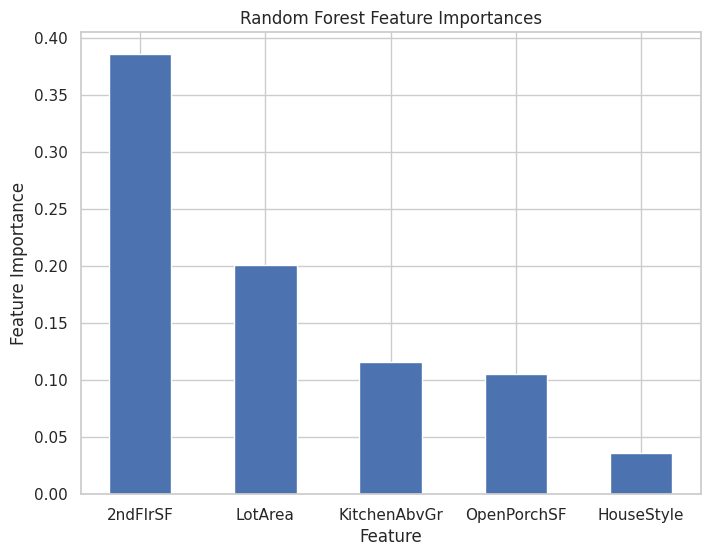

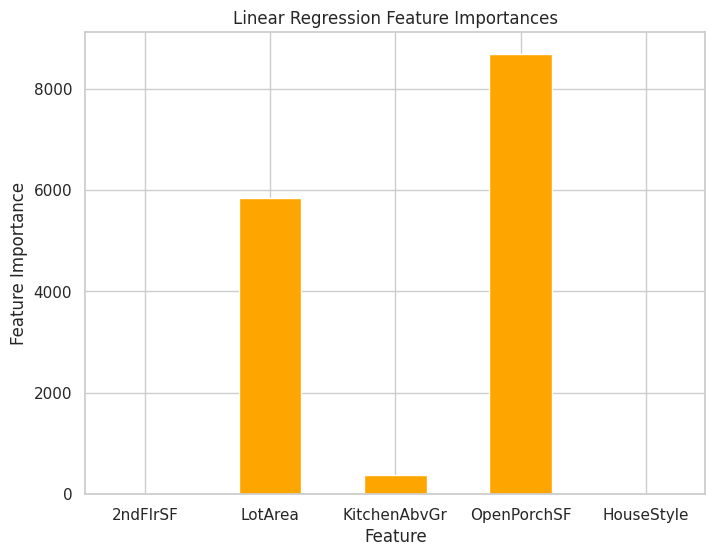

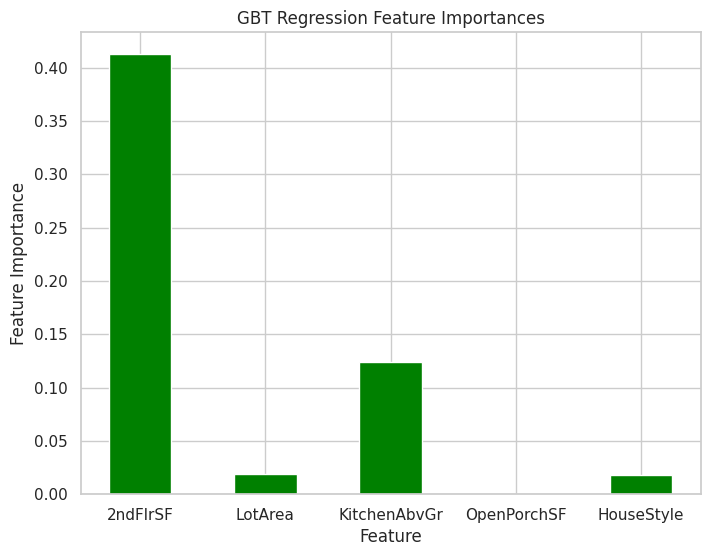

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the feature names
feature_names = train_df.columns[:-1]

# Define the feature importances as a numpy array
rf_importances = rf_model.featureImportances.toArray()
lr_importances = np.abs(lr_coeffs)
gbt_importances = gbt_model.featureImportances.toArray()

# Create a DataFrame with the feature names and their importances for each model
importances_df = pd.DataFrame({'Feature': feature_names,
                               'RF Importance': rf_importances,
                               'LR Importance': lr_importances,
                               'GBT Importance': gbt_importances})

# Sort the DataFrame by the RF importance column in descending order
importances_df = importances_df.sort_values('RF Importance', ascending=False)

# Only keep the top 5 features
importances_df = importances_df.head(5)

# Define the y-axis values and set the bar width
y_pos = np.arange(len(importances_df))
bar_width = 0.5

# Create a bar chart for Random Forest
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(y_pos, importances_df['RF Importance'], bar_width)
ax.set_xticks(y_pos)
ax.set_xticklabels(importances_df['Feature'])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Random Forest Feature Importances')

plt.show()

# Create a bar chart for Linear Regression
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(y_pos, importances_df['LR Importance'], bar_width, color='orange')
ax.set_xticks(y_pos)
ax.set_xticklabels(importances_df['Feature'])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Linear Regression Feature Importances')

plt.show()

# Create a bar chart for GBT Regression
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(y_pos, importances_df['GBT Importance'], bar_width, color='green')
ax.set_xticks(y_pos)
ax.set_xticklabels(importances_df['Feature'])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('GBT Regression Feature Importances')

plt.show()
  

In [ ]:
import pandas as pd

# Define the feature names
feature_names = train_df.columns[:-1]

# Define the feature importances as a numpy array
rf_importances = rf_model.featureImportances.toArray()
lr_importances = np.abs(lr_coeffs)
gbt_importances = gbt_model.featureImportances.toArray()

# Create a DataFrame with the feature names and their importances for each model
importances_df = pd.DataFrame({'Feature': feature_names,
                               'RF Importance': rf_importances,
                               'LR Importance': lr_importances,
                               'GBT Importance': gbt_importances})

# Sort the DataFrame by the RF importance column in descending order
importances_df = importances_df.sort_values('RF Importance', ascending=False)

# Select top 5 important features for each model
top_5_rf = importances_df[['Feature', 'RF Importance']].head(5)
top_5_lr = importances_df[['Feature', 'LR Importance']].sort_values('LR Importance', ascending=False).head(5)
top_5_gbt = importances_df[['Feature', 'GBT Importance']].head(5)

# Merge the top 5 features for each model into a single DataFrame
top_5_df = pd.merge(top_5_rf, top_5_lr, on='Feature', how='outer')
top_5_df = pd.merge(top_5_df, top_5_gbt, on='Feature', how='outer')

# Display the top 5 features for each model
print(top_5_df)


        Feature  RF Importance  LR Importance  GBT Importance
0      2ndFlrSF       0.385446            NaN        0.412438
1       LotArea       0.201204    5836.417193        0.018665
2  KitchenAbvGr       0.115728            NaN        0.124247
3   OpenPorchSF       0.105064    8677.653027        0.000519
4    HouseStyle       0.036347            NaN        0.018031
5     GrLivArea            NaN   32701.421887             NaN
6      FullBath            NaN   31615.434880             NaN
7     ExterQual            NaN    8002.361594             NaN


## Problems Encountered

* After plotting the distribution of the data we can see that the the data is not only right skewed which can be seen by observing the normal distribution but also it is biased which can be seen by observing the sigma distribution

* The dataset contained a lot of features and was challenging to decide which features to use.
scaling can help generalize the data points, improving the skewness of the model but in our case scaling did not make any significant difference

* The percentage of Null values and outliers were much more and it required proper handling in order to prevent biases and overfitting.


# 5. Conclusion and Future Scope

# Conclusion

* We have explored the Ames Housing Dataset to predict the sale prices of houses in Ames, Iowa. We started with data cleaning and feature engineering, where we handled missing values and transformed some features. We then performed exploratory data analysis and visualizations to understand the relationships between different features and the target variable.

* We used three different regression models: Linear Regression, Random Forest, and Gradient Boosted Trees. We evaluated the performance of each model using RMSE, R-squared values and mean percentage differences. Tree structure performs exceptionally well when handing outliers which is considered hard for Regression algorithms. 

* Our results show that Linear Regression outformed Gradient Boosted Trees and Random Forest in all measures. It produced the highest R-square values, lowest RMSE values and had a mean percentage difference of 9.95%.

* We also conducted inference on each model to gain insight into the importance of different features in predicting sale prices. The important features for the Random Forest and GBT models were found to be the quality of the house, the second floor area of the house, the lot area, and the exterior quality of the house. The linear regression had different importance features such as  exterior quality of the house, ground living area, full bath and open porch sqft

* Overall, our analysis demonstrates the potential of machine learning algorithms to predict house prices accurately. This information can be beneficial to real estate agents and potential buyers in the Ames area.


#Future Scope

* Since we see some more Nan values in our importance matrix, there is a scope to perform PCA (Principal component analysis) , to focus on the important features and build a model that predicts with greater accuracy.
* We will aim to reduce the Mean Percentage Difference in Pricing.
* We can also try and build our model on ML libraries not supported on Pyspark such as XGBoost, Svm, etc.


# References

* Madhuri, C. R., Anuradha, G., & Pujitha, M. V. (2019, March). House price prediction using regression techniques: A comparative study. In 2019 International conference on smart structures and systems (ICSSS) (pp. 1-5). IEEE.

* Varma, A., Sarma, A., Doshi, S., & Nair, R. (2018, April). House price prediction using machine learning and neural networks. In 2018 second international conference on inventive communication and computational technologies (ICICCT) (pp. 1936-1939). IEEE.

* Thamarai, M., & Malarvizhi, S. P. (2020). House Price Prediction Modeling Using Machine Learning. International Journal of Information Engineering & Electronic Business, 12(2).